# MessMaster: the Curse of the Muffin-Faced Dog (part 2)

<div>
<img src="media/domino_meme.png" width="400"/>
</div>

Welcome back to the quest of MessMaster! 

This week, we will continue to help Boltzmann differentiate Chihuahuas and blueberry muffins, but with fancier models (no longer just linear)!

<div>
<img src="../lab2/media/chihuahua_muffin.png" width="400"/>
</div>

Specifically we will use the following concepts:

- Backprop: implementation and visualization
- MLP: decision boundary and contrast with linear models
- Optimization: Comparing SGD v.s. Adam

A friend has helped us found a separable 2D embedding of Chihuahuas and blueberry muffins.
However, it is not linearly separable!

<div>
<img src="secret/data/xor_pattern_label.png" width="400"/>
</div>


We will train a MLP to help with this!


#### 1. ManualGrad: handcrafted gradients, artisanal machine learning

Backprop is the process of computing the gradient of the loss function w.r.t. all the parameters from multiple stages of nonlinear transformations of the input. 

It is efficient both in terms of computation and memory and is universally used for computing the gradient and in well-implemented in many widely used tools (e.g., ```torch.autograd```). 

Today, we will implement backprop by hand  for a 2-layer MLP because it's a good exercise for understanding backprop :) 

First we will load the data and split it into train/val/test sets.

**Q1a.** Why is it important to have validation and test sets?

Answer: 

We can use the validation set to tune the hyperparameters and the test set to evaluate the performance of the model. 

We need the test set, which is separate from both the training and validation sets, to evaluate the performance of the model on unseen data.

In [1]:
# For reproducibility
RANDOM_SEED = 10011  # postal code of CDS <3

import torch
from sklearn.model_selection import train_test_split
import pandas as pd

# load data
df = pd.read_csv("secret/data/xor_pattern.csv")
X = df[["x1", "x2"]].values  # Extract features
y = df["y"].values  #

# train-val-test split
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=RANDOM_SEED)
# TODO: what is the train-val-test split ratio?

# convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

Next, we define the loss function as the cross entropy loss. When we update the weights, we use the gradient of the loss function w.r.t. the weights.

**Q1b.** Implement the CEL loss function for binary classification. What is its connection to energy?

Answer: For cross entropy loss, the energy is the negative log likelihood of the correct class.

$L_{\text{CE}}(y, p_{\hat{y}}) = - \log p_{\hat{y}}(\hat{y}=y)$.

In code, we first find the probability of the correct class by indexing into the probability tensor from softmax.

Then we compute the mean of the negative log likelihood across all examples.



In [2]:
def loss_fn(p_y_hat: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    """
    Compute the cross-entropy loss (negative log likelihood) of a prediction.
    p_y_hat: probability of each class, shape (N, 2)
    y: true class, shape (N,)
    returns: loss, shape (1,)
    """
    # TODO: implement the loss function
    # step 1: fine the probability of the correct class
    correct_class_loc = [range(y.shape[0]), y]
    correct_class_prob = p_y_hat[correct_class_loc]
    # step 2: compute the mean of the negative log likelihood across all examples
    nll = -torch.mean(torch.log(correct_class_prob))
    return nll
    # return 0 

Before we dive into implementing the gradients, let's do a brief calculus review to make sure we have the background knowledge.

**Q1c.** 

i. What does derivative/gradient tells us about a function? (What does positive/negative gradient mean?)

ii. Why is it useful for optimization?

iii. What is chain rule and why is it relevant to backprop?

Answer: 

i. The derivative of a function tells us the rate of change of the function. A positive derivative means the function increases if we increase the parameter by a little bit. A negative derivative means the function decreases if we increase the parameter by a little bit (conversely, the function increases if we decrease the parameter by a little bit). The direction of the gradient tells us the direction of the function's increase.

ii. It is useful for optimization because we can use it to find the minimum or maximum of a function by following the gradient.

iii. The chain rule is a rule in calculus for differentiating the composition of two functions. If $f(x) = h(g(x))$, then $f'(x) = h'(g(x)) * g'(x)$.

It is relevant to backprop because to compute the gradient of the loss function w.r.t. the first layer's parameters, we need to use the gradients of the loss function w.r.t. the later layer's parameters and the gradients of the later layer's parameters w.r.t. the first layer's parameters.

**Q1d.**

We are going to implement a two-layer MLP with ReLU activation and softmax output.

First layer: $z_1 = h_1(x) = \sigma(W_1 x + b_1)=\sigma(a_1)$

Second layer: $z_2 = h_2(x) = W_2 z_1 + b_2$

Softmax: $\hat{p} = \text{softmax}(z_2) = \frac{e^{z_2}}{\sum_{j=1}^{2} e^{z_{2j}}}$

Loss function: $L(y, p_{\hat{y}}) = \text{L}_{\text{ce}}(y, p_{\hat{y}}) = - \log \hat{p}(\hat{y}=y)$

Consider computing the gradient of the loss function with respect to the parameters.

Let's focus on the first layer. What is $\frac{\partial L}{\partial W_1}$?

You may use the fact that $\frac{\partial L}{\partial z_2} = \hat{p} - y$ and that $\sigma'(a) = 1(\sigma(a) > 0)$, where $1(\cdot)$ is the indicator function.


<div>
<img src="media/grad_math.jpeg" width="800"/>
</div>

Answer:

<div>
<img src="media/grad_math_sol.jpeg" width="800"/>
</div>




**Q1e. Verification of gradients implementation**

Check the gradients and gradient updates. Anything looks wrong?
If you find something wrong, try to fix it.

In [ ]:
# Initialize weights
d = 2 # input dimension
h = 10 # hidden dimension
k = 2 # number of classes
W1 = torch.randn(d, h, requires_grad=False) * 0.01
b1 = torch.zeros(h, requires_grad=False)
W2 = torch.randn(h, k, requires_grad=False) * 0.01
b2 = torch.zeros(k, requires_grad=False)

learning_rate = 0.1
epochs = 10000

for epoch in range(epochs):
    # =================== Forward pass ===================
    # First layer: z1 = W1 * X + b1
    z1 = X_train_tensor @ W1 + b1  # Shape: (N, h)  [batch_size, hidden_dim]

    # Apply activation function: a1 = ReLU(z1)
    a1 = torch.relu(z1)  # Shape: (N, h)

    # Second layer: z2 = W2 * a1 + b2
    z2 = a1 @ W2 + b2  # Shape: (N, k)  [batch_size, num_classes]

    # Apply softmax to get probabilities: p_hat = softmax(z2)
    p_hat = torch.softmax(z2, dim=1)   # Shape: (N, k)

    # =================== Compute Loss ===================
    # PyTorch's CrossEntropyLoss automatically applies softmax inside,
    # so we should pass raw logits (z2), not softmax probabilities (p_hat)
    loss = loss_fn(p_hat, y_train_tensor)  # Scalar loss value

    # =================== Backpropagation ===================

    # Step 1: Compute gradient of loss w.r.t. logits (z2)
    # Cross-entropy loss with softmax:
    #   L = - (1/N) * sum(y * log(p_hat))
    # Derivative:
    #   dL/dz2 = (p_hat - y) / N
    # Shape: (N, k) [Same as z2]
    y_one_hot = torch.nn.functional.one_hot(y_train_tensor, num_classes=p_hat.shape[1]).float()  # Shape: (N, k)
    dL_dz2 = (p_hat - y_one_hot) / y_train_tensor.shape[0]  # Normalize by batch size

    # Step 2: Compute gradient of loss w.r.t. W2 and b2
    # Using chain rule: dL/dW2 = (dL/dz2) * (dz2/dW2)
    #   dz2/dW2 = a1^T
    #   dL/dW2 = a1^T @ dL/dz2
    # Shape: (h, k) [Same as W2]
    dL_dW2 = a1.T @ dL_dz2

    # Gradient of loss w.r.t. b2:
    #   dL/db2 = sum(dL/dz2) along batch axis
    # Shape: (k,) [Same as b2]
    dL_db2 = torch.sum(dL_dz2, dim=0)

    # Step 3: Compute gradient of loss w.r.t. activations (a1)
    #   dL/da1 = (dL/dz2) * (dz2/da1)
    #   dz2/da1 = W2^T
    #   dL/da1 = dL/dz2 @ W2^T
    # Shape: (N, h) [Same as a1]
    dL_da1 = dL_dz2 @ W2.T 

    # Step 4: Compute gradient of loss w.r.t. pre-activation (z1)
    # Using chain rule: dL/dz1 = (dL/da1) * (da1/dz1)
    # ReLU derivative:
    #   da1/dz1 = 1 if z1 > 0, else 0
    # Shape: (N, h) [Same as z1]
    dL_dz1 = dL_da1 * (z1 > 0).float() 

    # Step 5: Compute gradient of loss w.r.t. W1 and b1
    # Using chain rule: dL/dW1 = (dL/dz1) * (dz1/dW1)
    #   dz1/dW1 = X^T
    #   dL/dW1 = X^T @ dL/dz1
    # Shape: (d, h) [Same as W1]
    # TODO: check if this is correct
    dL_dW1 = X_train_tensor.T @ dL_dz1 

    # Gradient of loss w.r.t. b1:
    #   dL/db1 = sum(dL/dz1) along batch axis
    # Shape: (h,) [Same as b1]
    dL_db1 = torch.sum(dL_dz1, dim=0)

    # Gradient update (SGD step)
    W1 -= learning_rate * dL_dW1
    b1 -= learning_rate * dL_db1
    W2 -= learning_rate * dL_dW2
    b2 -= learning_rate * dL_db2
    # TODO: check here
    # W1 += learning_rate * dL_dW1
    # b1 += learning_rate * dL_db1
    # W2 += learning_rate * dL_dW2
    # b2 += learning_rate * dL_db2

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.4f}")

Epoch 0: Loss = 0.6931
Epoch 10: Loss = 0.6910
Epoch 20: Loss = 0.6903
Epoch 30: Loss = 0.6900
Epoch 40: Loss = 0.6898
Epoch 50: Loss = 0.6897
Epoch 60: Loss = 0.6897
Epoch 70: Loss = 0.6896
Epoch 80: Loss = 0.6895
Epoch 90: Loss = 0.6894
Epoch 100: Loss = 0.6892
Epoch 110: Loss = 0.6890
Epoch 120: Loss = 0.6888
Epoch 130: Loss = 0.6885
Epoch 140: Loss = 0.6881
Epoch 150: Loss = 0.6876
Epoch 160: Loss = 0.6869
Epoch 170: Loss = 0.6862
Epoch 180: Loss = 0.6852
Epoch 190: Loss = 0.6839
Epoch 200: Loss = 0.6824
Epoch 210: Loss = 0.6804
Epoch 220: Loss = 0.6779
Epoch 230: Loss = 0.6749
Epoch 240: Loss = 0.6712
Epoch 250: Loss = 0.6666
Epoch 260: Loss = 0.6611
Epoch 270: Loss = 0.6545
Epoch 280: Loss = 0.6468
Epoch 290: Loss = 0.6379
Epoch 300: Loss = 0.6277
Epoch 310: Loss = 0.6162
Epoch 320: Loss = 0.6033
Epoch 330: Loss = 0.5890
Epoch 340: Loss = 0.5732
Epoch 350: Loss = 0.5558
Epoch 360: Loss = 0.5369
Epoch 370: Loss = 0.5165
Epoch 380: Loss = 0.4951
Epoch 390: Loss = 0.4729
Epoch 400: 

**Visualization**

Now let's visualize the decision boundary of the trained MLP.

Can linear models learn this decision boundary?

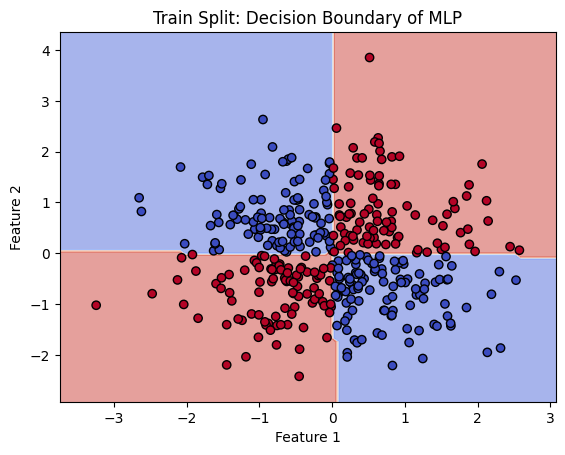

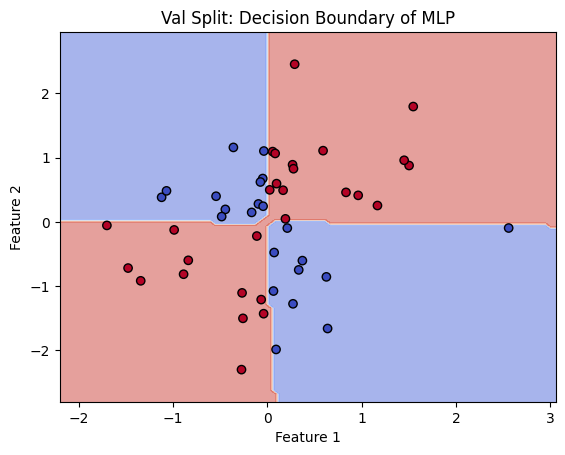

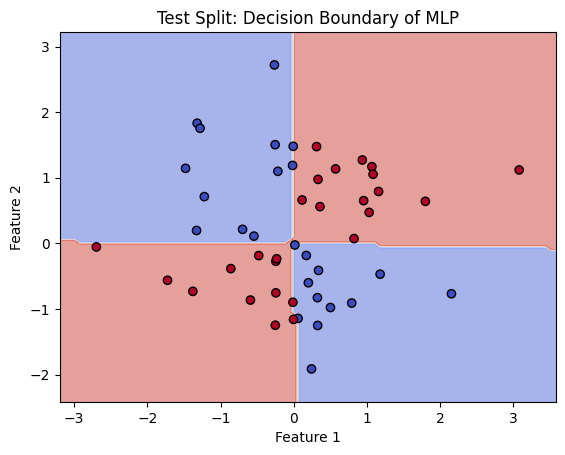

In [15]:
from util import plot_decision_boundary
# Example usage:
plot_decision_boundary(W1, b1, W2, b2, X_train_tensor.numpy(), y_train_tensor.numpy(), split="Train")
plot_decision_boundary(W1, b1, W2, b2, X_val_tensor.numpy(), y_val_tensor.numpy(), split="Val")
plot_decision_boundary(W1, b1, W2, b2, X_test_tensor.numpy(), y_test_tensor.numpy(), split="Test")

#### 2. Optimizers: Adam v.s. SGD

Great that the MLP worked! However, we can further accelerate the training process by dynamically adjusting the learning rate.

**Q2a.** What was the learning rate scheduler we used above?

Answer: 

we used a constant learning rate of 0.1.



In class, we learned about the Adam optimizer, which uses exponential smoothing to reduce the variance of the gradient estimate and normalizes the update using an estimate of the second moment of the gradient.

$$ \theta_t^i \leftarrow \theta_{t-1}^i + \alpha \frac{m_t^i}{\sqrt{v_t^i + \epsilon}},$$

where $\alpha$ is the default learning rate, $m_t$ is the momentum (exponential moving average of the gradient), and $v_t$ is the adpative scaling (exponential moving average of the squared gradient).
$$m_t \leftarrow \beta_1 m_{t-1} + (1-\beta_1) g_t.$$
$$v_t \leftarrow \beta_2 v_{t-1} + (1-\beta_2) g_t^2.$$

**Q2b.** Why is it momentum helpful? Why is adaptive scaling helpful?

Answer: 

Momentum helps by adding a "inertia" to the update, which smoothes out noisy gradients, speed up convergence in flat regions, and can help the optimizer escape shallow local minima.

Adaptive scaling helps by normalizing the update using an estimate of the second moment of the gradient, which reduces the learning rate in steep or high-curvature regions, and increases it in flat regions.

**Q2c.** Observe the loss curves of SGD and Adam. What do you see?

In [5]:
import torch
import torch.nn.functional as F

W1.requires_grad = True
W2.requires_grad = True
b1.requires_grad = True
b2.requires_grad = True
# Hyperparameters
epochs = 10000
batch_size = 32
learning_rate = 0.1 #1e-3

# Initialize weights with Xavier (Glorot) initialization
torch.manual_seed(RANDOM_SEED)  # For reproducibility
torch.nn.init.xavier_uniform_(W1)
torch.nn.init.xavier_uniform_(W2)
b1.data.fill_(0)
b2.data.fill_(0)

# Define two optimizers: SGD and Adam
optimizer_sgd = torch.optim.SGD([W1, b1, W2, b2], lr=learning_rate)
optimizer_adam = torch.optim.Adam([W1, b1, W2, b2], lr=learning_rate)

# Learning rate schedulers (optional)
# scheduler_sgd = torch.optim.lr_scheduler.StepLR(optimizer_sgd, step_size=20, gamma=0.5)  # Decay every 20 epochs
# scheduler_adam = torch.optim.lr_scheduler.StepLR(optimizer_adam, step_size=20, gamma=0.5)

# Store loss & lr history
loss_history_sgd, loss_history_adam = [], []
lr_history_sgd, lr_history_adam = [], []

# Training loop for both optimizers
for optimizer_name, optimizer, loss_history, lr_history in [
    ("SGD", optimizer_sgd, loss_history_sgd, lr_history_sgd),
    ("Adam", optimizer_adam, loss_history_adam, lr_history_adam),
]:
    print(f"\nTraining with {optimizer_name}...\n")

    # Reset weights for fair comparison
    torch.nn.init.xavier_uniform_(W1)
    torch.nn.init.xavier_uniform_(W2)
    b1.data.fill_(0)
    b2.data.fill_(0)

    for epoch in range(epochs):
        # =================== Forward pass ===================
        z1 = X_train_tensor @ W1 + b1
        a1 = torch.relu(z1)
        z2 = a1 @ W2 + b2
        loss = F.cross_entropy(z2, y_train_tensor)

        # =================== Backward pass ===================
        optimizer.zero_grad()  # Reset gradients
        loss.backward()  # Compute gradients
        optimizer.step()  # Update weights

        # Save loss & learning rate
        loss_history.append(loss.item())

        lr_history.append(optimizer.param_groups[0]["lr"])  # Extract current lr

        # Learning rate decay (if scheduler exists)
        # scheduler.step()

        # Print progress every 10 epochs
        if epoch % 10 == 0:
            print(
                f"{optimizer_name} - Epoch {epoch}: Loss = {loss.item():.4f}, LR = {optimizer.param_groups[0]['lr']:.6f}"
            )


Training with SGD...

SGD - Epoch 0: Loss = 0.7869, LR = 0.100000
SGD - Epoch 10: Loss = 0.6714, LR = 0.100000
SGD - Epoch 20: Loss = 0.6108, LR = 0.100000
SGD - Epoch 30: Loss = 0.5689, LR = 0.100000
SGD - Epoch 40: Loss = 0.5383, LR = 0.100000
SGD - Epoch 50: Loss = 0.5104, LR = 0.100000
SGD - Epoch 60: Loss = 0.4834, LR = 0.100000
SGD - Epoch 70: Loss = 0.4571, LR = 0.100000
SGD - Epoch 80: Loss = 0.4320, LR = 0.100000
SGD - Epoch 90: Loss = 0.4081, LR = 0.100000
SGD - Epoch 100: Loss = 0.3857, LR = 0.100000
SGD - Epoch 110: Loss = 0.3650, LR = 0.100000
SGD - Epoch 120: Loss = 0.3460, LR = 0.100000
SGD - Epoch 130: Loss = 0.3286, LR = 0.100000
SGD - Epoch 140: Loss = 0.3128, LR = 0.100000
SGD - Epoch 150: Loss = 0.2984, LR = 0.100000
SGD - Epoch 160: Loss = 0.2853, LR = 0.100000
SGD - Epoch 170: Loss = 0.2734, LR = 0.100000
SGD - Epoch 180: Loss = 0.2625, LR = 0.100000
SGD - Epoch 190: Loss = 0.2525, LR = 0.100000
SGD - Epoch 200: Loss = 0.2434, LR = 0.100000
SGD - Epoch 210: Loss 

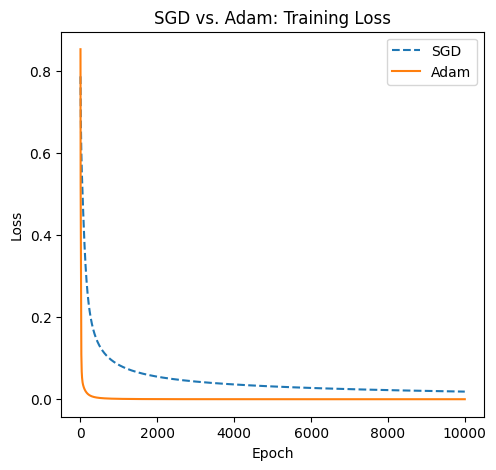

In [6]:
from util import plot_loss
plot_loss(loss_history_sgd, loss_history_adam)